# Model Selection - Bias-Variance Decomposition

We start by settung up an example regression problem - The ground truth is a polynomial of degree 3, $f(x)$ and we assume data samples $(x, y)$ with $x \sim \textrm{Uniform}(-4, 2)$ and $y = f(x) + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 1)$.

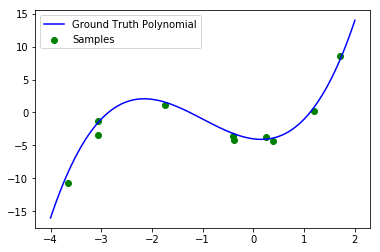

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # always seed your random numbers for reproducability 

# pick some coefficientes
coefficients = [1, 3, -1, -4]  

def evaluate_polynomial(coefficients: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    evaluates a 1-D polynomial with coefficients "coefficients" at points "x"
    :param coefficients: coefficients of polynomial
    :param x: points to evaluate at
    
    Note: A similar function (np.polyval) is provided by numpy, we only "reimplemented" it for clarity
    """    
    poly = 0
    degree = len(coefficients) - 1
    for i, c in enumerate(coefficients):
        poly += c * x**(degree - i)
    return poly 

x_plt = np.linspace(-4, 2, 101) 
y_plt = evaluate_polynomial(coefficients, x_plt)
x_samples = np.random.uniform(-4, 2, size=10)
y_samples = evaluate_polynomial(coefficients, x_samples) + np.random.normal(size=10)

# plotting
plt.plot(x_plt, y_plt, c="blue", label="Ground Truth Polynomial")
plt.scatter(x_samples, y_samples, c="green", label="Samples")
plt.legend()



To exactly measure the bias and variance in our estimators we would need to train infinitely many estimatiors on infintly many different datasets and evaluate each on infinitly many test points. Unfortunately, we are a poor university and have to settle for small rather values of infinity. 

Let us generate inifinitly many datasets $D_n$ and a test set. 

In [2]:
infinity = 1000

x_inf_datasets = np.random.uniform(-3, 2, size=(infinity, 10))
y_inf_datasets_gt = evaluate_polynomial(coefficients, x_inf_datasets)
y_inf_datasets = y_inf_datasets_gt + np.random.normal(size=(infinity, 10))

x_test = np.random.uniform(-3, 2, size=infinity)
y_test_gt = evaluate_polynomial(coefficients, x_test)
y_test = y_test_gt + np.random.normal(size=infinity)


In the following we will use the numpy function polyfit to learn polynomial estimators of varying degrees. 
For each degree, we first going to fit an "average estimator" $\hat{f}_*(x)$ to all datapoints from all datasets to approximate the optimal estimator for the given order of polynomials. 
Then we fit one estimator for each of the datasets and compute MSE, variance and bias:

MSE 
$$ \mathbb{E}_{D_n}\left[\mathbb{E}_{x,y}\left[\left(\hat{f}_{D_n}(x) -y\right)^2\right]\right] $$

Variance:
$$ \mathbb{E}_{D_n}\left[\mathbb{E}_{x,y}\left[\left(\hat{f}_{D_n}(x) - \hat{f}_*(x) \right)^2\right]\right]$$

Bias:
$$ \mathbb{E}_{x, y} \left[ \left( \hat{f}_*(x) - f(x) \right)^2\right] $$ 

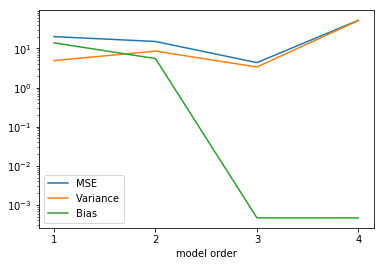

In [6]:
max_order = 4  # train polynomials up to order M
poly_orders = range(1, max_order + 1)

errors = np.zeros(max_order)
variances = np.zeros(max_order)
biases = np.zeros(max_order)

for m in poly_orders:

    # We first need to train the "average estimate", i.e., a model on trained infinitly many data points.
    # We just reuse the datapoints from all datasets generated before. 
    x_inf = x_inf_datasets.reshape(-1)
    y_inf = y_inf_datasets.reshape(-1)
    avg_estimator = np.polyfit(x_inf, y_inf , m)
    avg_estimator_predictions = evaluate_polynomial(avg_estimator, x_test)
    
    # We now need to train one model per dataset and evaluate it on the infinitly large test set    
    predictions = np.zeros([infinity, infinity])
    for i, (x, y) in enumerate(zip(x_inf_datasets, y_inf_datasets)):
        model = np.polyfit(x, y, m)
        predictions[i] = evaluate_polynomial(model, x_test)
    
    all_mse = np.mean((predictions - y_test[None, :])**2, axis=1)
    mse = np.mean(all_mse)
    
    all_vars = np.mean((predictions - avg_estimator_predictions[None, :])**2, axis=1)
    var = np.mean(all_vars)
    
    # Difference of true function and best possible estimator in class (i.e., estimator trained on infinitly
    # large dataset)
    bias = np.mean((avg_estimator_predictions - y_test_gt)**2)
    
    # recording
    errors[m - 1] = mse
    variances[m - 1] = var
    biases[m - 1] = bias

# plotting    
plt.semilogy(poly_orders, errors, label="MSE")
plt.semilogy(poly_orders, variances, label="Variance")
plt.semilogy(poly_orders, biases, label="Bias")
plt.xticks(poly_orders)
plt.xlabel("model order")
plt.legend()